# [Chefkoch.de](http://www.chefkoch.de/) Maturaarbeit 2017/18
------

# Convolutional Neural Network

## Ziel: 
### Training vom ersten Model mit [Cloud Computing Power](https://neptune.ml/)

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import matplotlib
import numpy as np
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torch.utils.data as data
from torchvision import transforms, models

%matplotlib inline

import os
from os import walk
from os import listdir
from os.path import isfile, join

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
import pathlib

data_dir = pathlib.Path("./input/images/images")

image_count = len(list(data_dir.glob('*/*.jpeg')))
print(image_count)

108823


In [4]:
train_size = int(image_count*0.15)
val_size = int(image_count*0.05)
test_size = image_count - train_size - val_size
batch_size = 128

print(train_size)

16323


In [5]:
transform = transforms.Compose([transforms.Resize(224),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                               transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])


dataset = torchvision.datasets.ImageFolder('./input/images/images/', transform=transform)
train, val, test = data.random_split(dataset, [train_size, val_size, test_size])

trainLoader = data.DataLoader(train, batch_size=batch_size, shuffle=True)
valLoader = data.DataLoader(val, batch_size=batch_size, shuffle=True)
testLoader = data.DataLoader(test, batch_size=batch_size, shuffle=True)

In [6]:
class_names = dataset.classes
print(class_names)

['ananas', 'apfel', 'apfelkuchen', 'aprikosen', 'art', 'asiatische', 'auberginen', 'auflauf', 'avocado', 'bananen', 'bananenkuchen', 'bandnudeln', 'basilikum', 'beeren', 'birnen', 'blechkuchen', 'blumenkohl', 'blätterteig', 'blätterteigtaschen', 'bohnen', 'bohnensalat', 'bohnensuppe', 'bolognese', 'bowle', 'bratapfel', 'bratkartoffeln', 'brokkoli', 'brot', 'brotaufstrich', 'brownies', 'bruschetta', 'brötchen', 'burger', 'butter', 'bärlauch', 'cake', 'cannelloni', 'cappuccino', 'carpaccio', 'champignon', 'champignons', 'cheesecake', 'chicken', 'chili', 'chinakohl_eintopf', 'chutney', 'cocktail', 'cookies', 'couscous', 'cremesuppe', 'cupcakes', 'curry', 'curry_con_carne', 'dinkel_vollkornbrot', 'dip', 'dressing', 'eier', 'eierlikör', 'eierlikörkuchen', 'eiersalat', 'einfache', 'einfacher', 'eingelegte', 'eintopf', 'eis', 'ente', 'entenbrust', 'erbsensuppe', 'erdbeer', 'erdbeeren', 'error', 'feigen', 'feine', 'feldsalat', 'fenchel', 'feta', 'fisch', 'fischfilet', 'fladenbrot', 'flammkuche

kartoffeln


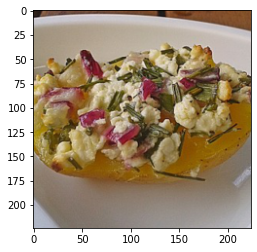

In [7]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

images,labels = next(iter(testLoader))
imshow(images[0])
print(class_names[labels[0]])


In [8]:
print(images.shape)

torch.Size([128, 3, 224, 224])


## Kategorien die sich ähneln oder keinen Mehwert ergeben (z.B "griechische", "weisse", "blech",...) werden gelöscht. Es bleiben noch 230 Kategorien

In [9]:
vgg16 = models.vgg16(pretrained=True)
vgg16.to(device)

print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:
vgg16.classifier[6].out_features = 300

for para in vgg16.features.parameters():
    para.requires_grad = False

In [11]:
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [12]:
def validate(model, test_dataloader):
    model.eval()
    val_running_loss = 0
    val_running_correct = 0
    for i, data in enumerate(test_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        output = model(data)
        loss = criterion(output, target)
        
        val_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        val_running_correct += (preds == target).sum().item()
    
    val_loss = val_running_loss/len(test_dataloader.dataset)
    val_accuracy = 100 * val_running_correct/len(test_dataloader.dataset)
    
    print(f'Validation Loss: {val_loss:.4f}, Validation Acc: {val_accuracy:.2f}')

    
    return val_loss, val_accuracy

In [13]:
def fit(model, train_dataloader):
    model.train()
    train_running_loss = 0
    train_running_correct = 0
    for i, data in enumerate(train_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        
        train_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100 * train_running_correct/len(train_dataloader.dataset)
    
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}')
    
    return train_loss, train_accuracy

In [ ]:
train_loss, train_accuracy = [], []
val_loss, val_accuracy = [], []
start = time.time()
for epoch in range(10):
    train_epoch_loss, train_epoch_accuracy = fit(vgg16, trainLoader)
    val_epoch_loss, val_epoch_accuracy = validate(vgg16, valLoader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
end = time.time()
print((end-start)/60, 'minutes')

Train Loss: 0.0446, Train Acc: 29.91
Validation Loss: 0.0372, Validation Acc: 33.19
Train Loss: 0.0351, Train Acc: 34.30
Validation Loss: 0.0344, Validation Acc: 33.38
